<a href="https://colab.research.google.com/github/Eason0227/Aidea-AOI/blob/main/AOI_InceptionResNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AOI/aoi/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


## Check image imformation

image shape: (512, 512, 3)
data type: uint8
min: 109, max: 255


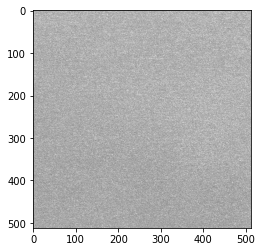

In [ ]:
TRAIN_IMAGEPATH = '/content/drive/My Drive/Colab Notebooks/AOI/aoi/train_images/'
img = cv2.imread( os.path.join( TRAIN_IMAGEPATH, df.loc[0,"ID"]))
print(f"image shape: {img.shape}")
print(f"data type: {img.dtype}")
print(f"min: {img.min()}, max: {img.max()}")
plt.imshow(img)
plt.show()

## Label : Defect type
---
0:normal  
1:void  
2:horizontal defect  
3:vertical defect  
4:edge defect  
5:particle

In [ ]:
normal_list = df[df["Label"]==0]["ID"].values
void_list = df[df["Label"]==1]["ID"].values
horizontal_defect_list = df[df["Label"]==2]["ID"].values
vertical_defect_list = df[df["Label"]==3]["ID"].values
edge_defect_list = df[df["Label"]==4]["ID"].values
particle_list = df[df["Label"]==5]["ID"].values
label = [normal_list,void_list,horizontal_defect_list,vertical_defect_list,edge_defect_list,particle_list]
defect = ['normal','void','horizontal defect','vertical defect','edge defect','particle']

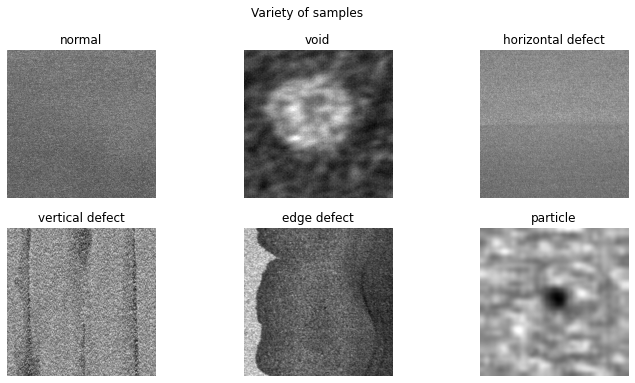

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2, 3, i+1)
  img = cv2.imread( os.path.join( TRAIN_IMAGEPATH, label[i][i]),0)
  plt.imshow(img,cmap='gray')
  plt.axis("off")
  plt.title(defect[i])
plt.suptitle(f"Variety of samples", fontsize=12)
plt.show()

## Check the distribution of label

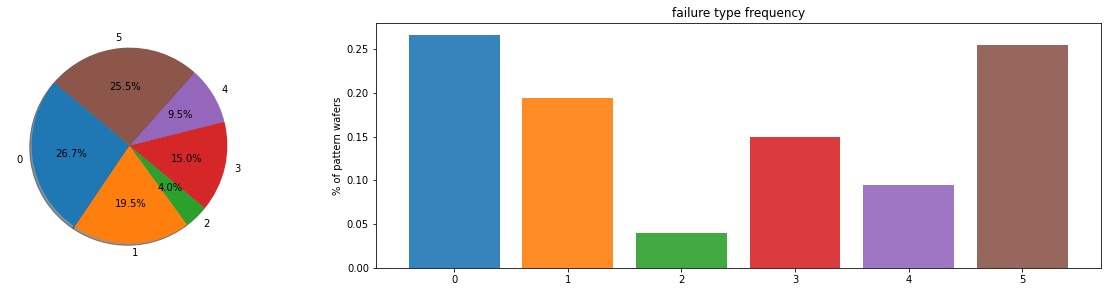

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

uni_pattern = np.unique( df['Label'], return_counts=True)

ax1.pie( uni_pattern[1], labels = uni_pattern[0], autopct='%1.1f%%', shadow=True, startangle=140)
color_set = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']

ax2.bar( uni_pattern[0] ,uni_pattern[1]/ df.shape[0], color = color_set ,align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
plt.show()

## Training and validation data

In [ ]:
train,valid= train_test_split(df,test_size=0.2,random_state=42)

train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)

train["Label"]=train["Label"].astype("str")
valid["Label"]=valid["Label"].astype("str")

## Dealing with data imbalance
Add a larger penalty value weight to the category with a small number of samples

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique, counts = np.unique( train["Label"].values , return_counts=True)
print("unique ", unique)
print("counts: ", counts)

class_weights = compute_class_weight(class_weight='balanced', classes= unique, y = train["Label"])
print(class_weights)

unique  ['0' '1' '2' '3' '4' '5']
counts:  [537 401  77 310 195 502]
[0.62756052 0.840399   4.37662338 1.08709677 1.72820513 0.67131474]


## Data Augmentation


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=0,
         horizontal_flip = False,
         vertical_flip = False,
         width_shift_range = 0.05,
         height_shift_range = 0.05,
         preprocessing_function = preprocess_input )

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

## Input training and validation pictures
Using flow_from_dataframe does not need to mark the pictures, just place them all in one folder, but it is necessary to make a DataFrame, which must contain the name and label of the picture

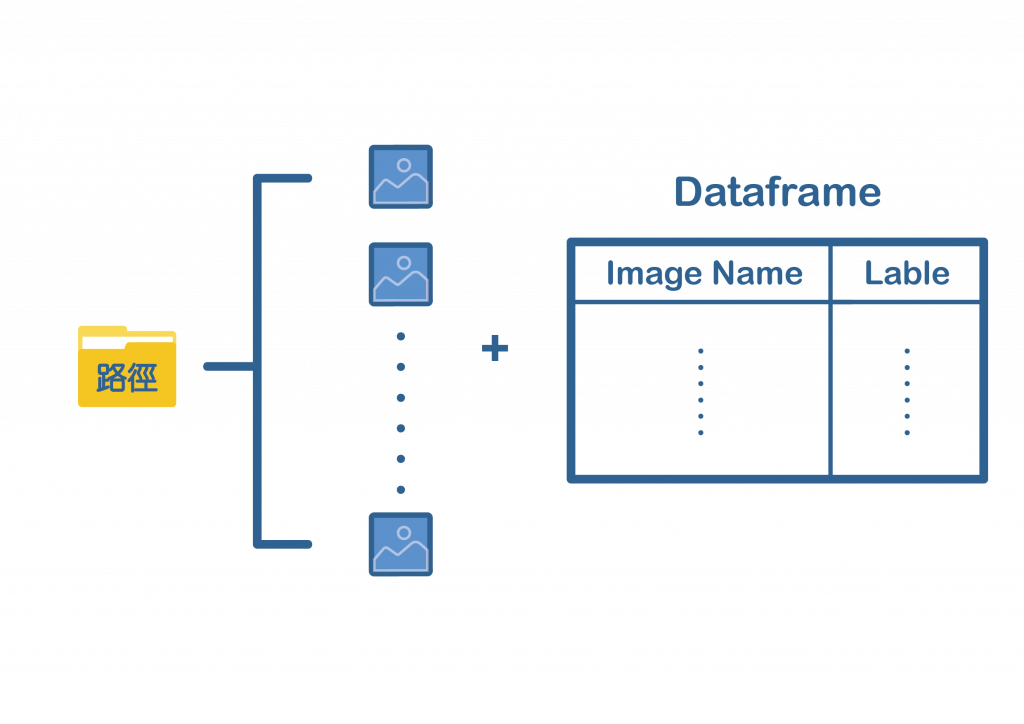

In [ ]:
# img_shape should be set according to the input limit of the model
img_shape = (128,128)
batch_size = 16

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                            directory= TRAIN_IMAGEPATH,
                            x_col="ID",
                            y_col="Label",
                            target_size=img_shape,
                            batch_size=batch_size,
                            class_mode='categorical',
                            shuffle=True)

valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid,
                            directory= TRAIN_IMAGEPATH,
                            x_col="ID",
                            y_col="Label",
                            target_size=img_shape,
                            batch_size=batch_size,
                            class_mode='categorical',
                            shuffle=True)

Found 2022 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


## Set the number of pictures for each epoch training

In [ ]:
steps_per_epoch_train = len(train_generator)
steps_per_epoch_val= len(valid_generator)
steps_per_epoch_train

127

# Bulid model

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Model

# Load the pre-trained model inception_resnet_v2, apply the weight of imagenet
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights='imagenet', input_tensor=Input(shape=(128,128,3)))

# Define the output layer, update the number of categories of the output
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax')(x)
model = Model( inputs = model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
       loss='categorical_crossentropy',
       metrics=['accuracy'])

## Set the model training mechanism

In [ ]:
#model.layers[0].trainable=False
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Used to store the model with the highest accuracy during the training process
checkpoint = ModelCheckpoint('InceptionResNetV2_checkpoint_v2.h5', verbose=1,
                monitor='val_accuracy', save_best_only=True)

# dynamic learning rate
reduce_learning_rate= ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                    patience=5, mode='min', verbose=1,
                    min_learning_rate=1e-5)

# earlystop：If the model does not improve for a 10 consecutive epochs, then terminate the model training early
estop = EarlyStopping(monitor='val_loss', patience=10,verbose=1)

callbacks_list = [checkpoint, estop,reduce_learning_rate]

# Increase the penalty weight for data imbalance
class_weights = {i:value for i, value in enumerate(class_weights)}

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
history=model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch_train,
                      epochs=50,
                      validation_data=valid_generator,
                      validation_steps = steps_per_epoch_val,
                      class_weight = class_weights,
                      callbacks = callbacks_list)

Epoch 1/50
127/127 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7794
Epoch 1: val_accuracy improved from -inf to 0.68379, saving model to InceptionResNetV2_checkpoint_v2.h5
127/127 [==============================] - 150s 334ms/step - loss: 0.6506 - accuracy: 0.7794 - val_loss: 0.8309 - val_accuracy: 0.6838 - lr: 1.0000e-04
Epoch 2/50
127/127 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9496
Epoch 2: val_accuracy improved from 0.68379 to 0.96443, saving model to InceptionResNetV2_checkpoint_v2.h5
127/127 [==============================] - 51s 399ms/step - loss: 0.1670 - accuracy: 0.9496 - val_loss: 5.2961 - val_accuracy: 0.9644 - lr: 1.0000e-04
Epoch 3/50
127/127 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9624
Epoch 3: val_accuracy improved from 0.96443 to 0.98024, saving model to InceptionResNetV2_checkpoint_v2.h5
127/127 [==============================] - 42s 330ms/step - loss: 0.1207 - accuracy: 0.9624

## Save and load model

In [ ]:
from keras.models import load_model

model.save('/content/drive/My Drive/Colab Notebooks/AOI/aoi/InceptionResNetV2_retrained_v2.h5')
incep_saved = load_model('/content/drive/My Drive/Colab Notebooks/AOI/aoi/InceptionResNetV2_retrained_v2.h5')

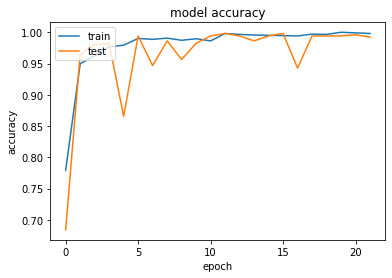

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left') 
plt.show()

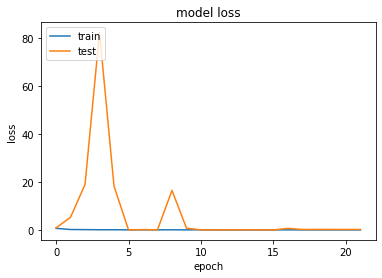

In [ ]:
# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left') 
plt.show()

## Testing data prediction

In [ ]:
test_list = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AOI/aoi/test.csv',index_col=False)
test_list['Label'] = '7'

In [ ]:
TEST_IMAGEPATH = '/content/drive/My Drive/Colab Notebooks/AOI/aoi/test_images/'

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_dataframe( dataframe=test_list,
                directory = TEST_IMAGEPATH,
                x_col="ID",
                y_col="Label",
                target_size=img_shape,
                batch_size=batch_size,
                # class_mode='categorical',
                shuffle=False)
test_steps = len(test_generator)

Found 10142 validated image filenames belonging to 1 classes.


In [ ]:
#The prediction will be a probability, so it needs to be converted
y_test_predprob = incep_saved.predict(test_generator, steps = test_steps)
y_test_pred = y_test_predprob.argmax(-1)
y_test_pred

634/634 [==============================] - 4307s 7s/step


array([1, 2, 5, ..., 1, 3, 1])

In [ ]:
test_list['Label'] = y_test_pred
test_list.to_csv('/content/drive/My Drive/Colab Notebooks/AOI/aoi/submit.csv')

## Final submission result

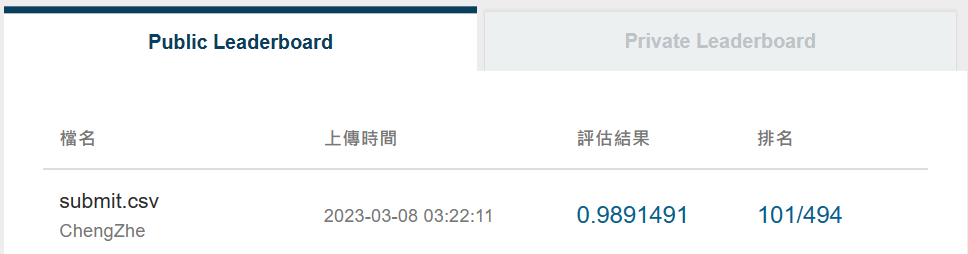